<a href="https://colab.research.google.com/github/sheikhi-a/Animated-Visualization/blob/main/Detecting_Risky_situations__in__work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
pip install mediapipe opencv-python tensorflow scikit-learn


In [16]:

import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [17]:

print(os.listdir('/content'))  # List all files in content directory
video_path = '/content/volmatch2.mp4'  # Update with your file name


def extract_frames(video_path, output_dir='/content/frames'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames to {output_dir}")

extract_frames(video_path)



mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def detect_keypoints_from_frames(frame_dir, output_csv='/content/keypoints.csv'):
    data = []
    for frame_file in sorted(os.listdir(frame_dir)):
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)

        # Convert to RGB and detect pose landmarks
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb_frame)

        if results.pose_landmarks:
            keypoints = [(lm.x, lm.y) for lm in results.pose_landmarks.landmark]
            flattened_keypoints = [coord for point in keypoints for coord in point]  # Flatten list
            data.append([frame_file] + flattened_keypoints)

    # Save keypoints to CSV
    num_keypoints = len(data[0]) - 1  # Exclude frame column
    columns = ['Frame'] + [f'Keypoint_{i}' for i in range(num_keypoints)]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_csv, index=False)
    print(f"Keypoints saved to {output_csv}")

detect_keypoints_from_frames('/content/frames')

['.config', 'volmatch2.mp4', '.ipynb_checkpoints', 'sample_data']
Extracted 363 frames to /content/frames
Keypoints saved to /content/keypoints.csv


Frames saved in /content/frames
Keypoints saved to /content/keypoints.csv
Model training complete.


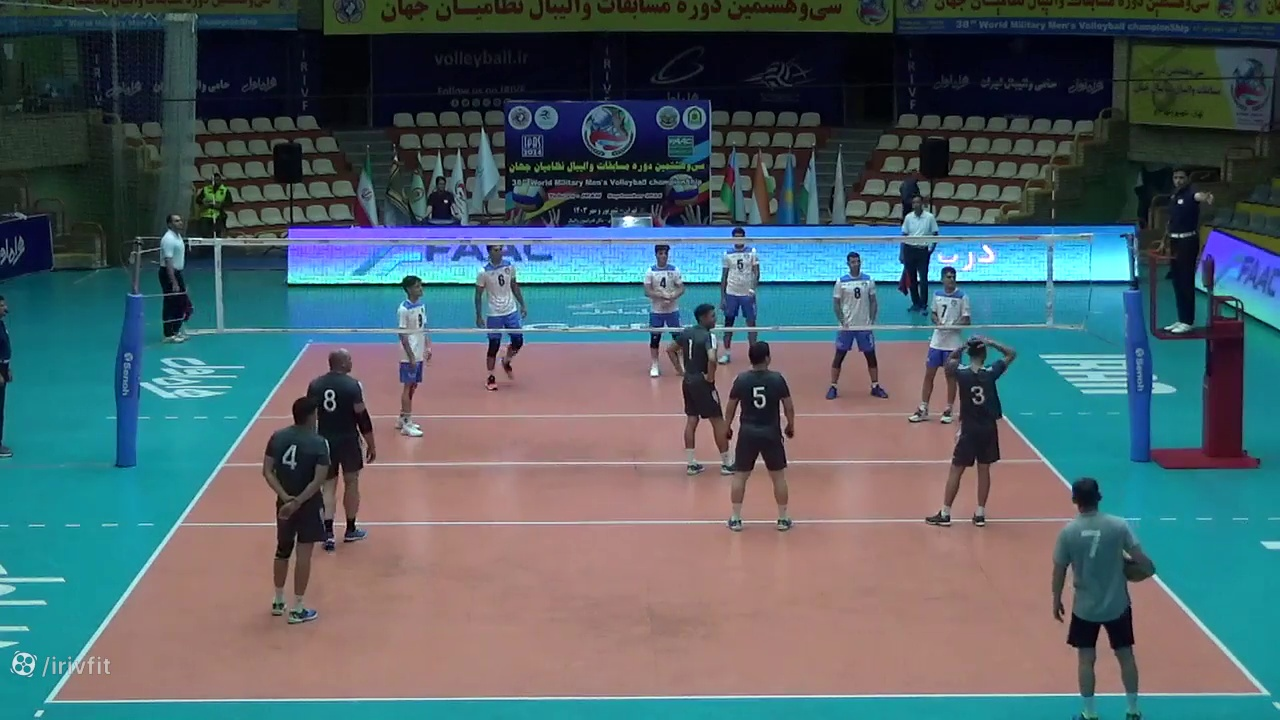

Safe situation.


In [19]:
#!pip install opencv-python mediapipe pandas numpy
from google.colab.patches import cv2_imshow

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.7)

def extract_frames(video_path, output_dir, frame_interval=1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success = True
    while success:
        success, frame = cap.read()
        if frame_count % frame_interval == 0 and success:
            frame_filename = f"{output_dir}/frame_{frame_count}.jpg"
            cv2.imwrite(frame_filename, frame)
        frame_count += 1
    cap.release()
    print(f"Frames saved in {output_dir}")

def detect_keypoints_from_frames(frame_dir, output_csv):
    data = []
    for frame_file in sorted(os.listdir(frame_dir)):
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        if frame is None:
            continue

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb_frame)

        if results.pose_landmarks:
            keypoints = [(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]
            flattened_keypoints = [coord for point in keypoints for coord in point]
            data.append([frame_file] + flattened_keypoints)

    if data:
        num_keypoints = len(data[0]) - 1
        columns = ['Frame'] + [f'Keypoint_{i}' for i in range(num_keypoints)]
        df = pd.DataFrame(data, columns=columns)
        df.to_csv(output_csv, index=False)
        print(f"Keypoints saved to {output_csv}")
    else:
        print("No keypoints were detected.")

def train_model(dummy_csv):
    df = pd.read_csv(dummy_csv)
    keypoint_data = df.drop(columns=["Frame"]).values
    labels = np.random.choice([0, 1], len(keypoint_data))

    X_train, X_test, y_train, y_test = train_test_split(keypoint_data, labels, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    print("Model training complete.")
    return model

def predict_dangerous_frame(model, frame_file):
    frame = cv2.imread(frame_file)
    if frame is None:
        return "Frame could not be loaded."

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)
    if results.pose_landmarks:
        keypoints = [(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]
        flattened_keypoints = [coord for point in keypoints for coord in point]
        prediction = model.predict([flattened_keypoints])[0]
        return "Dangerous situation detected." if prediction == 1 else "Safe situation."
    else:
        return "No keypoints detected in the frame."

video_path = '/content/volmatch2.mp4'
frame_dir = '/content/frames'
keypoints_csv = '/content/keypoints.csv'

extract_frames(video_path, frame_dir, frame_interval=30)

detect_keypoints_from_frames(frame_dir, keypoints_csv)

model = train_model(keypoints_csv)

sample_frame = '/content/frames/frame_30.jpg'
frame = cv2.imread(sample_frame)

cv2_imshow(frame)
result = predict_dangerous_frame(model, sample_frame)
print(result)
